AMV Historical Data

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm tensorflow

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [3]:
df = pd.read_csv('AMV Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

df["Vol."] = df["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

df["Change %"] = df["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [4]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,3700.0,3600.0,3800.0,3600.0,1440000,0.0278
1,05/30/2024,3600.0,3600.0,3800.0,3500.0,3230000,0.0286
2,05/29/2024,3500.0,3500.0,3600.0,3500.0,522679,0.0000
3,05/28/2024,3500.0,3500.0,3600.0,3500.0,452540,0.0000
4,05/27/2024,3500.0,3500.0,3600.0,3500.0,660470,0.0000
...,...,...,...,...,...,...,...
1308,03/07/2019,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
1309,03/06/2019,14594.0,14414.0,14684.0,14414.0,17250,0.0125
1310,03/05/2019,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
1311,03/04/2019,14865.0,15180.0,15180.0,14865.0,19010,-0.0236


In [5]:
print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.          int64
Change %    float64
dtype: object


In [6]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [8]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [9]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [10]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [11]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [12]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0750 - val_loss: 0.0031
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - val_loss: 0.0020
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045 - val_loss: 9.3016e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 9.0763e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - l

In [13]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [14]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [15]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [16]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1019, number of used features: 1
[LightGBM] [Info] Start training from score 0.351571
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [17]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [18]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    y_true = y_true[nonzero_indices]
    y_pred = y_pred[nonzero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Calculate evaluation metrics
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
msle = mean_squared_log_error(y_test_inverse, y_pred_inverse)

# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')

Root Mean Squared Error (RMSE): 681.0016436825233
Mean Absolute Percentage Error (MAPE): 3.803616504315879
Mean Squared Logarithmic Error (MSLE): 0.0022377791714463043


In [20]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [21]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [22]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [23]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

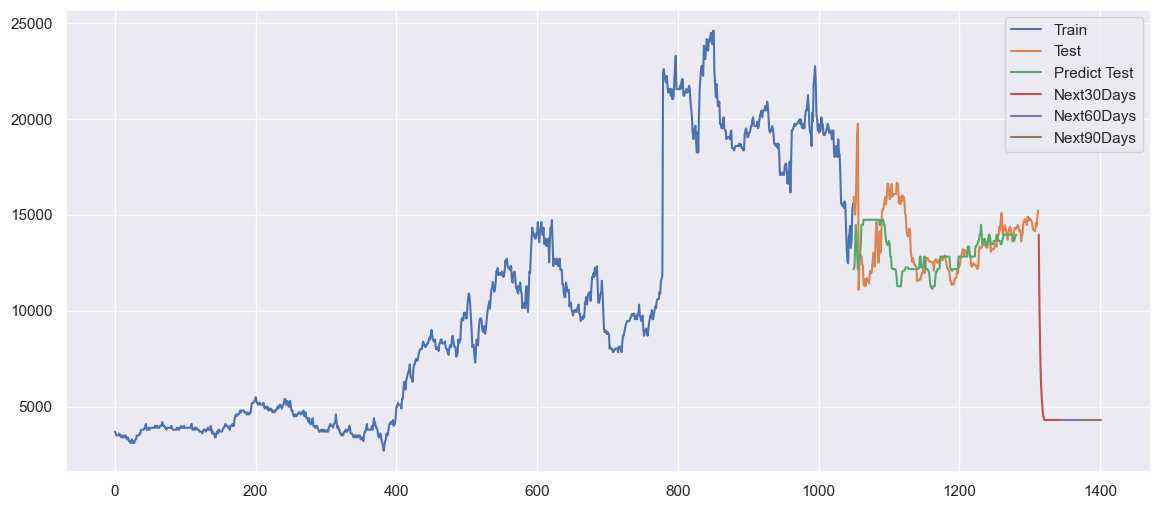

In [24]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Predicting and plotting on test data
test_predictions = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Adjust test_data_index to match the length of test_predictions
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_predictions), step=1)
plt.plot(test_data_index, test_predictions, label='Test Predictions')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Next 30 Days Predictions')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Next 60 Days Predictions')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Next 90 Days Predictions')

plt.legend(['Train', 'Test', 'Predict Test', 'Next30Days','Next60Days', 'Next90Days'])
plt.show()

DHT Historical Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [26]:
df = pd.read_csv('DHT Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

df["Vol."] = df["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

df["Change %"] = df["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [27]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [28]:
print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.          int64
Change %    float64
dtype: object


In [29]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [30]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [31]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [32]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [33]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [34]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [35]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0377 - val_loss: 0.0016
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022 - val_loss: 7.2340e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 6.9513e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 7.4400e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - val_loss: 7.2338e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014 - val_loss: 6.6364e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 6.6169e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014 - val_loss: 6.0404e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 6.8623e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.7391e-04 - val_loss: 5.5506e-04
Epoch 12/100
16/16 ━━━━━

In [36]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [37]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [38]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [39]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1018, number of used features: 1
[LightGBM] [Info] Start training from score 0.263769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [40]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [41]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    y_true = y_true[nonzero_indices]
    y_pred = y_pred[nonzero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [42]:
# Calculate evaluation metrics
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
msle = mean_squared_log_error(y_test_inverse, y_pred_inverse)

# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')

Root Mean Squared Error (RMSE): 2543.6693414025026
Mean Absolute Percentage Error (MAPE): 17.830733611006128
Mean Squared Logarithmic Error (MSLE): 0.04404694036355762


In [43]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [44]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [45]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [46]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

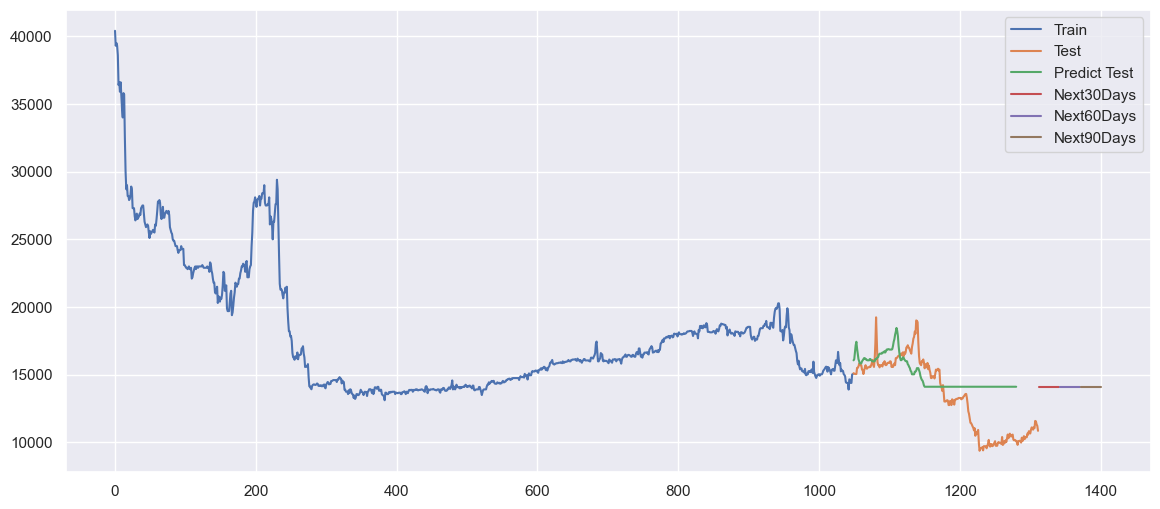

In [47]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Predicting and plotting on test data
test_predictions = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Adjust test_data_index to match the length of test_predictions
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_predictions), step=1)
plt.plot(test_data_index, test_predictions, label='Test Predictions')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Next 30 Days Predictions')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Next 60 Days Predictions')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Next 90 Days Predictions')

plt.legend(['Train', 'Test', 'Predict Test', 'Next30Days','Next60Days', 'Next90Days'])
plt.show()

DP3 Historical Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [50]:
df = pd.read_csv('DP3 Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume):
    if isinstance(volume, str):
        if volume[-1] == 'K':
            return int(float(volume[:-1]) * 1000)
        elif volume[-1] == 'M':
            return int(float(volume[:-1]) * 1000000)
        elif volume[-1] == 'B':
            return int(float(volume[:-1]) * 1000000000)
        else:
            return int(volume)
    else:
        return volume

df["Vol."] = df["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

df["Change %"] = df["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str_value):
    return float(str_value.replace(',', ''))

df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [51]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10510.0,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5110.0,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7300.0,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7900.0,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12670.0,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11570.0,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3810.0,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7330.0,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8340.0,0.0149


In [52]:
print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


In [53]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [54]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [55]:
# Split data into training and testing sets
train_size = int(0.8 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [56]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [57]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [58]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [59]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0764 - val_loss: 0.0023
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0140 - val_loss: 5.7167e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0077 - val_loss: 6.8708e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065 - val_loss: 5.1980e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059 - val_loss: 5.2685e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - val_loss: 6.3144e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055 - val_loss: 4.1681e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - val_loss: 4.5848e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052 - val_loss: 7.5631e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 6.0459e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049 - val_loss: 5.3711e-04
Epoch 12/100
14/14 ━━━━━

In [60]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [61]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [62]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [63]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 1
[LightGBM] [Info] Start training from score 0.378833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [64]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [65]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    y_true = y_true[nonzero_indices]
    y_pred = y_pred[nonzero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [66]:
# Calculate evaluation metrics
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
msle = mean_squared_log_error(y_test_inverse, y_pred_inverse)

# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')

Root Mean Squared Error (RMSE): 1912.3700277723924
Mean Absolute Percentage Error (MAPE): 2.3638798804418903
Mean Squared Logarithmic Error (MSLE): 0.0008126701678593888


In [67]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [68]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [69]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [70]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

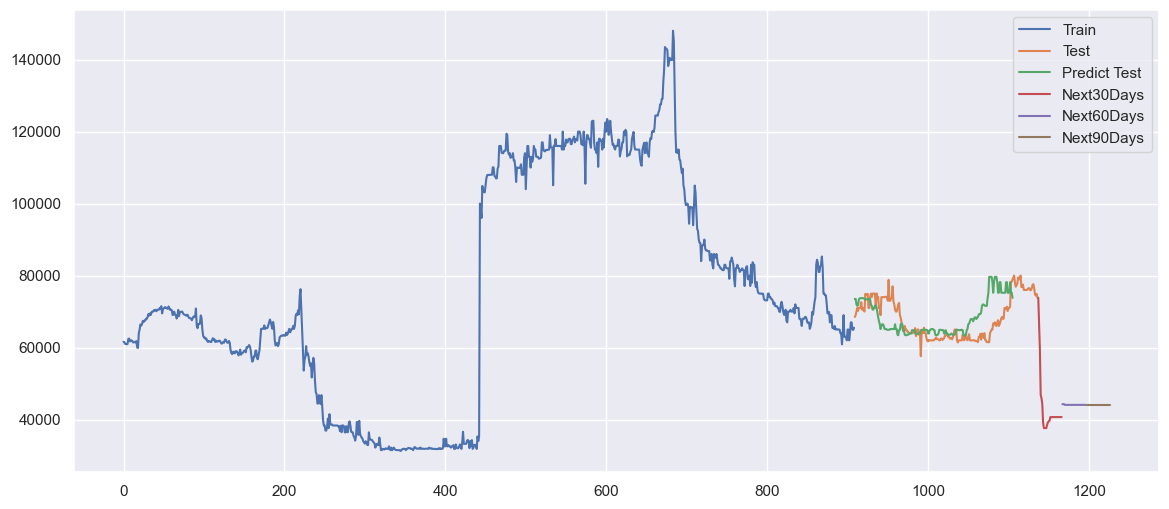

In [71]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Predicting and plotting on test data
test_predictions = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Adjust test_data_index to match the length of test_predictions
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_predictions), step=1)
plt.plot(test_data_index, test_predictions, label='Test Predictions')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Next 30 Days Predictions')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Next 60 Days Predictions')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Next 90 Days Predictions')

plt.legend(['Train', 'Test', 'Predict Test', 'Next30Days','Next60Days', 'Next90Days'])
plt.show()